## Importing packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
import sklearn as sk
import statsmodels as sm
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn import metrics
pd.set_option('mode.chained_assignment', None) # For SettingWithCopyWarning

In [3]:
features = pd.read_csv('features.csv', parse_dates = ['Date'])
stores = pd.read_csv('stores.csv')

In [4]:
train = pd.read_csv('train.csv', parse_dates = ['Date'])
test = pd.read_csv('test.csv',  parse_dates = ['Date'])

In [5]:
train = pd.merge(train, features, on = ['Store', 'Date', 'IsHoliday'])
train = pd.merge(train, stores, on = 'Store')

In [6]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [7]:
test = pd.merge(test, features, on = ['Store', 'Date', 'IsHoliday'])
test = pd.merge(test, stores, on = 'Store')

In [8]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


#### converting data into weekly level

In [9]:
days = [(x - train.Date[0]) for x in train.Date]
train['Weeks'] = [i.days for i in [x/7 for x in days]]

In [10]:
days = [(x - test.Date[0]) for x in test.Date]
test['Weeks'] = [i.days for i in [x/7 for x in days]]

In [11]:
train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
Weeks                    int64
dtype: object

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
Type            421570 non-null object
Size            421570 non-null int64
Weeks           421570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 75.1+ MB


In [13]:
train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Weeks                0
dtype: int64

In [14]:
test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Weeks               0
dtype: int64

#### Exporting pandas profiling output to html file

In [15]:
report = pandas_profiling.ProfileReport(train)
report.pd.to_file(output_file = 'pandas_profiling.html')

#### Splitting Numeric and Categorical variables

In [16]:
numeric_vars_name = [key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['int64', 'float64']]
cat_vars_name = [key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object', 'bool']]

In [17]:
numeric_vars_name

['Store',
 'Dept',
 'Weekly_Sales',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Size',
 'Weeks']

In [18]:
cat_vars_name

['IsHoliday', 'Type']

In [19]:
train_num = train[numeric_vars_name]

numeric_vars_name.remove('Weekly_Sales')
test_num = test[numeric_vars_name]

In [20]:
train_cat = train[cat_vars_name]
test_cat = test[cat_vars_name]

#### replace all negative and zero values with missing

In [21]:
train_num[train_num <= 0] = np.nan
test_num[test_num <= 0] = np.nan

In [22]:
train_num.isna().sum()

Store                0
Dept                 0
Weekly_Sales      1358
Temperature         69
Fuel_Price           0
MarkDown1       270889
MarkDown2       311840
MarkDown3       284803
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Size                 0
Weeks             2955
dtype: int64

## Data Audit Report

In [23]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [24]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [25]:
train_num.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,421570.0,0.0,9.359084e+06,22.200546,22.00000,12.785297,1.634638e+02,1.000,1.000000,3.000000,5.000000,11.000000,22.00000,33.000000,40.000000,43.000000,45.000000,45.000000
Dept,421570.0,0.0,1.865882e+07,44.260317,37.00000,30.492054,9.297654e+02,1.000,1.000000,4.000000,7.000000,18.000000,37.00000,74.000000,92.000000,95.000000,98.000000,99.000000
Weekly_Sales,420212.0,1358.0,6.737307e+09,16033.114591,7661.70000,22729.492116,5.166298e+08,0.010,7.440000,67.551000,311.186000,2120.130000,7661.70000,20271.265000,42922.748000,61275.522000,106566.351400,693099.360000
Temperature,421501.0,69.0,2.533231e+07,60.100233,62.09000,18.432294,3.397495e+02,5.540,18.360000,27.310000,33.990000,46.700000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
MarkDown1,150681.0,270889.0,1.091898e+09,7246.420196,5347.45000,8291.221345,6.874435e+07,0.270,17.760000,149.190000,375.200000,2240.270000,5347.45000,9210.900000,15282.470000,21801.350000,41524.030000,88646.760000
MarkDown2,109730.0,311840.0,3.710112e+08,3381.128457,203.26000,9532.362243,9.086593e+07,0.020,0.300000,3.000000,7.910000,44.200000,203.26000,1991.380000,8716.860000,16590.750000,50366.600000,104519.540000
MarkDown3,136767.0,284803.0,1.973339e+08,1442.847588,24.73000,9634.212338,9.281805e+07,0.010,0.150000,0.700000,1.710000,5.160000,24.73000,104.140000,400.090000,1059.900000,63143.290000,141630.610000
MarkDown4,134967.0,286603.0,4.566161e+08,3383.168256,1481.31000,6292.384031,3.959410e+07,0.220,3.970000,28.760000,108.710000,504.220000,1481.31000,3595.040000,7871.420000,12645.960000,35785.260000,67474.850000
MarkDown5,151432.0,270138.0,7.009750e+08,4628.975079,3359.45000,5962.887455,3.555603e+07,135.160,351.970000,715.520000,1070.830000,1878.440000,3359.45000,5563.800000,8337.700000,11269.240000,27754.230000,108519.280000


In [26]:
num_var_summary = train_num.apply(continuous_var_summary).T
num_var_summary.to_csv('num_var_summary.csv')

In [27]:
train_cat.apply(categorical_var_summary)

,IsHoliday,Type
N,421570,421570
NMISS,0,0
MODE,False,A
FREQ,391909,215478
PERCENT,92.96,51.11


### Missing Value Treatment

In [28]:
def missing_imputation(x):
    return x.fillna(x.median())

In [29]:
train_num = train_num.apply(missing_imputation)
test_num = test_num.apply(missing_imputation)

### Handling Outlier

In [30]:
train_num = train_num.apply(lambda x : x.clip(lower = x.dropna().quantile(0.05), upper = x.quantile(0.95)))
test_num = test_num.apply(lambda x : x.clip(lower = x.dropna().quantile(0.05), upper = x.quantile(0.95)))

### Creating Dummy Variables

In [31]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [32]:
for i in ['IsHoliday', 'Type']:
    train_cat = create_dummies(train_cat, i)
    test_cat = create_dummies(test_cat, i)

In [33]:
train_cat.head()

,IsHoliday_True,Type_B,Type_C
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [34]:
train = pd.concat([train_num, train_cat], axis = 1)
test = pd.concat([test_num, test_cat], axis = 1)

In [35]:
train.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Weeks,IsHoliday_True,Type_B,Type_C
0,3,4,24924.50,42.31,2.653,5347.45,203.26,24.73,1481.31,3359.45,211.096358,8.106,151315,72.0,0,0,0
1,3,4,50605.27,42.31,2.653,5347.45,203.26,24.73,1481.31,3359.45,211.096358,8.106,151315,72.0,0,0,0
2,3,4,13740.12,42.31,2.653,5347.45,203.26,24.73,1481.31,3359.45,211.096358,8.106,151315,72.0,0,0,0
3,3,4,39954.04,42.31,2.653,5347.45,203.26,24.73,1481.31,3359.45,211.096358,8.106,151315,72.0,0,0,0
4,3,5,32229.38,42.31,2.653,5347.45,203.26,24.73,1481.31,3359.45,211.096358,8.106,151315,72.0,0,0,0


In [36]:
# correlation matrix (ranges from 1 to -1)
corrm = train.corr()
corrm.to_csv("corrm.csv")
corrm

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Weeks,IsHoliday_True,Type_B,Type_C
Store,1.000000,0.024547,-0.077143,-0.052561,0.062560,-0.109868,-0.025493,-0.039585,-0.042612,-0.077730,-0.205784,0.243623,-0.181081,0.003222,-0.000552,-0.245708,0.442014
Dept,0.024547,1.000000,0.123195,0.004324,0.003318,-0.002819,-0.000075,0.001755,0.002776,-0.000174,-0.007375,0.009095,-0.003716,0.003871,0.000872,-0.029742,0.028559
Weekly_Sales,-0.077143,0.123195,1.000000,0.002109,0.002560,0.083990,0.013405,0.068797,0.062246,0.099209,-0.027362,-0.019742,0.257656,-0.001214,0.006599,-0.131243,-0.103919
Temperature,-0.052561,0.004324,0.002109,1.000000,0.138154,0.005878,-0.286271,-0.165590,0.044820,-0.040970,0.189349,0.073775,-0.058468,0.127505,-0.154139,-0.106118,0.134425
Fuel_Price,0.062560,0.003318,0.002560,0.138154,1.000000,0.112353,0.105904,0.082313,0.138789,0.049054,-0.154353,-0.033980,0.005248,0.767846,-0.075053,0.037624,-0.000983
MarkDown1,-0.109868,-0.002819,0.083990,0.005878,0.112353,1.000000,0.215213,0.127549,0.681660,0.443308,-0.032828,0.014047,0.301712,0.098404,-0.010764,-0.008325,-0.245708
MarkDown2,-0.025493,-0.000075,0.013405,-0.286271,0.105904,0.215213,1.000000,0.236252,0.207419,0.202466,-0.007426,-0.055525,0.087136,0.210834,0.115904,0.009108,-0.079216
MarkDown3,-0.039585,0.001755,0.068797,-0.165590,0.082313,0.127549,0.236252,1.000000,0.109528,0.268489,-0.005020,-0.056058,0.161215,0.219302,0.139366,-0.052144,-0.104094
MarkDown4,-0.042612,0.002776,0.062246,0.044820,0.138789,0.681660,0.207419,0.109528,1.000000,0.363988,-0.017052,-0.039915,0.173598,0.228804,-0.002864,-0.037122,-0.097040
MarkDown5,-0.077730,-0.000174,0.099209,-0.040970,0.049054,0.443308,0.202466,0.268489,0.363988,1.000000,0.027293,-0.042526,0.329432,0.126501,-0.022432,-0.113744,-0.201908


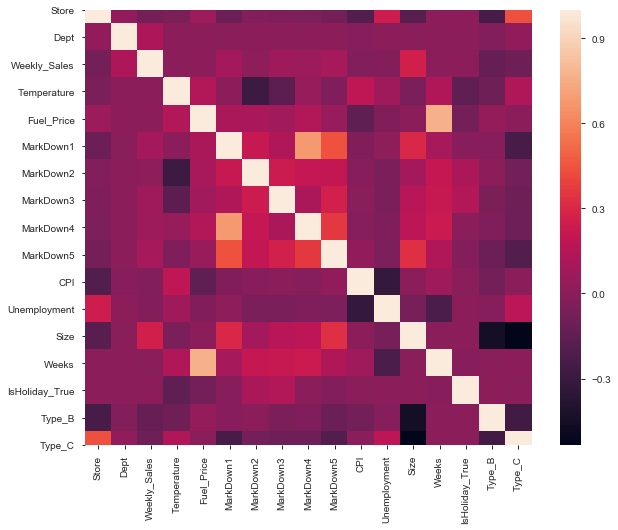

In [37]:
# ploting correlation matrix using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corrm)
plt.show()

## Building Linear Regression Model

In [38]:
lm = smf.ols('''Weekly_Sales ~ Store + Dept + Temperature + Fuel_Price + MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + 
                MarkDown5 + CPI + Unemployment + Size + Weeks + IsHoliday_True + Type_B + Type_C''', train).fit()

In [39]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2589.
Date:                Sat, 25 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:56:02   Log-Likelihood:            -4.6882e+06
No. Observations:              421570   AIC:                         9.376e+06
Df Residuals:                  421553   BIC:                         9.377e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5047.8301    387.423     13.

In [40]:
# final features after feature selection
lm = smf.ols('''Weekly_Sales ~ Store + Dept + Temperature + MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + 
                MarkDown5 + CPI + Unemployment + Size + Weeks + IsHoliday_True + Type_B + Type_C''', train).fit()

In [41]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2761.
Date:                Sat, 25 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:56:04   Log-Likelihood:            -4.6882e+06
No. Observations:              421570   AIC:                         9.376e+06
Df Residuals:                  421554   BIC:                         9.377e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5138.5004    277.760     18.

###### final features after feature selection
Store, Dept, Temperature, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Size, Weeks, IsHoliday_True, Type_B, Type_C, Weekly_Sales

In [42]:
train = train[['Store', 'Dept', 'Temperature', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 
              'Unemployment', 'Size', 'Weeks', 'IsHoliday_True', 'Type_B', 'Type_C', 'Weekly_Sales']]
test = test[['Store', 'Dept', 'Temperature', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 
              'Unemployment', 'Size', 'Weeks', 'IsHoliday_True', 'Type_B', 'Type_C']]

In [43]:
# divide the data into training and testing
train_X = train[train.columns.difference(['Weekly_Sales'])]
train_y = train.Weekly_Sales

test_X = test

## Decision Tree (DT)

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [45]:
tree_reg = DecisionTreeRegressor(max_depth = 5, random_state = 345)
tree_reg.fit(train_X, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=345, splitter='best')

In [46]:
predict_X = tree_reg.predict(train_X)

In [47]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 8764.190635500425
Mean Squared Error: 157983222.224655
Root Mean Squared Error: 12569.137688189076


In [48]:
print("R-squared for Train:",tree_reg.score(train_X, train_y))

R-squared for Train: 0.4617650229161202


In [49]:
scores = cross_val_score(tree_reg, train_X, train_y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

13112.846453498689

### Tuning a Decision Tree Model

In [50]:
# list of values to try
max_depth_range = range(8, 13)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []


for depth in max_depth_range:
    tree_reg = DecisionTreeRegressor(max_depth = depth, random_state = 345)
    
    MSE_scores = cross_val_score(tree_reg, train_X, train_y, cv = 14, scoring = 'neg_mean_squared_error', verbose = 0)
    
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [51]:
print(RMSE_scores)

[10478.843096818175, 10388.367394458968, 10096.124821150876, 9978.898974186091, 10119.10671603001]


Text(0, 0.5, 'RMSE (lower is better)')

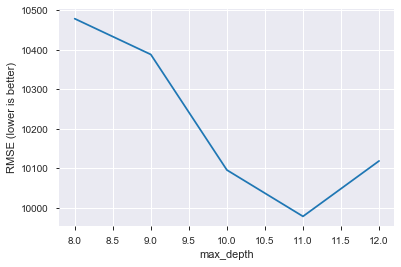

In [52]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

### Final Decision Tree Model

In [53]:
tree_reg = DecisionTreeRegressor(max_depth = 11, random_state = 345)
tree_reg.fit(train_X, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=345, splitter='best')

In [54]:
tree_reg.feature_importances_

array([1.66630158e-02, 7.18180804e-01, 5.12826057e-05, 1.10712987e-04,
       8.12297947e-05, 1.56795110e-03, 9.90376186e-05, 1.04911012e-04,
       1.94581020e-01, 3.92294782e-02, 2.96221881e-03, 1.45621139e-02,
       3.63112429e-03, 5.68341097e-03, 2.49168951e-03])

In [55]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature' : train_X.columns, 'importance' : tree_reg.feature_importances_})

,feature,importance
0,CPI,0.016663
1,Dept,0.718181
2,IsHoliday_True,0.000051
3,MarkDown1,0.000111
4,MarkDown2,0.000081
5,MarkDown3,0.001568
6,MarkDown4,0.000099
7,MarkDown5,0.000105
8,Size,0.194581
9,Store,0.039229


### Making predictions 

In [56]:
predict_X = tree_reg.predict(train_X)

In [57]:
dt = pd.DataFrame({'Actual' : train_y, 'Predicted' : predict_X, 'Week' : train.Weeks})
dt.head()

,Actual,Predicted,Week
0,24924.50,24343.159383,72.0
1,50605.27,24343.159383,72.0
2,13740.12,24343.159383,72.0
3,39954.04,24343.159383,72.0
4,32229.38,24343.159383,72.0


In [58]:
dt = dt.groupby('Week').apply(lambda x : np.mean(x))

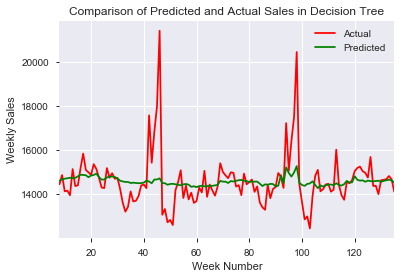

In [59]:
dt.plot(kind = 'line', x = 'Week', y = 'Actual', color = 'red', ax = plt.gca())
dt.plot(kind = 'line', x = 'Week', y = 'Predicted', color = 'green', ax = plt.gca())
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted and Actual Sales in Decision Tree')
plt.show()

In [60]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 4202.486864587649
Mean Squared Error: 56520497.18126118
Root Mean Squared Error: 7518.01151776593


In [61]:
print("R-squared for Train:",tree_reg.score(train_X, train_y))

R-squared for Train: 0.8074396250643252


##### Prediction on test data using Decision Tree Model

In [62]:
DT_Pred_Output = pd.read_csv('samplesubmission.csv')
DT_Pred_Output['Weekly_Sales'] = tree_reg.predict(test_X)
DT_Pred_Output.to_csv('DT_Pred_Output.csv')

## Random Forest (RF)

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [64]:
RF = RandomForestRegressor(max_depth = 10, n_estimators = 25, random_state = 0)  
RF.fit(train_X, train_y)  
predict_X = RF.predict(train_X) 

In [65]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))  
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 4511.606738150535
Mean Squared Error: 61136353.0974947
Root Mean Squared Error: 7818.973915898089


In [66]:
print("R-squared for Train:",RF.score(train_X, train_y))

R-squared for Train: 0.7917138089408664


### Tuning a Random Forest Model

In [67]:
param_grid={'max_depth': range(19, 25), 'n_estimators': (30, 50)}

In [68]:
gscv_rf = GridSearchCV(estimator = RandomForestRegressor(), 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose = 0, 
                       n_jobs = -1)
    
gscv_result = gscv_rf.fit(train_X, train_y)

### Building Final Random Forest Model

In [69]:
RF = RandomForestRegressor(max_depth = 25, n_estimators = 50, random_state = 0)
RF.fit(train_X, train_y)
predict_X = RF.predict(train_X)

In [70]:
dt = pd.DataFrame({ 'Actual' : train_y, 'Predicted' : predict_X, 'Week' : train.Weeks})
dt.head()

,Actual,Predicted,Week
0,24924.50,32541.278302,72.0
1,50605.27,32541.278302,72.0
2,13740.12,32541.278302,72.0
3,39954.04,32541.278302,72.0
4,32229.38,30856.082127,72.0


In [71]:
dt = dt.groupby('Week').apply(lambda x : np.mean(x))

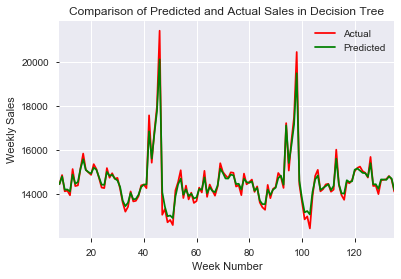

In [72]:
dt.plot(kind = 'line', x = 'Week', y = 'Actual', color = 'red', ax = plt.gca())
dt.plot(kind = 'line', x = 'Week', y = 'Predicted', color = 'green', ax = plt.gca())
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted and Actual Sales in Decision Tree')
plt.show()

In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 2004.9195838665144
Mean Squared Error: 32195153.57863554
Root Mean Squared Error: 5674.077332803593


In [74]:
print("R-squared for Train:",RF.score(train_X, train_y))

R-squared for Train: 0.8903139364763218


##### Prediction on test data using Random Forest Model

In [75]:
RF_Pred_Output = pd.read_csv('samplesubmission.csv')
RF_Pred_Output['Weekly_Sales'] = RF.predict(test_X)
RF_Pred_Output.to_csv('RF_Pred_Output.csv')

## Gradient Boosting (GBM)

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

In [77]:
GBMR = GradientBoostingRegressor()
GBMR.fit(train_X, train_y)
predict_X = GBMR.predict(train_X)

In [78]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))  
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 6441.464455784841
Mean Squared Error: 89330502.45081581
Root Mean Squared Error: 9451.481495025835


In [79]:
print("R-squared for Train:",GBMR.score(train_X, train_y))

R-squared for Train: 0.6956588157751679


### Tuning a Gradient Boosting Model

In [80]:
param_grid={'learning_rate' : [0.001, 0.01],
            'max_depth' : [5, 6]}

In [81]:
gscv_gbmr = GridSearchCV(estimator = GradientBoostingRegressor(), 
                        param_grid = param_grid, 
                        cv = 5,
                        verbose = True, n_jobs = -1)

In [82]:
gscv_result = gscv_gbmr.fit(train_X, train_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.3min finished


In [83]:
gscv_result.best_score_

0.5032936370937218

In [84]:
gscv_result.best_params_

{'learning_rate': 0.01, 'max_depth': 6}

### Final Gradient Boosting Model

In [85]:
gscv_gbmr = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 6)
gscv_gbmr.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
predict_X = gscv_gbmr.predict(train_X)

In [87]:
dt = pd.DataFrame({ 'Actual' : train_y, 'Predicted' : predict_X, 'Week' : train.Weeks})
dt.head()

,Actual,Predicted,Week
0,24924.50,19326.207688,72.0
1,50605.27,19326.207688,72.0
2,13740.12,19326.207688,72.0
3,39954.04,19326.207688,72.0
4,32229.38,18999.743533,72.0


In [88]:
dt = dt.groupby('Week').apply(lambda x : np.mean(x))

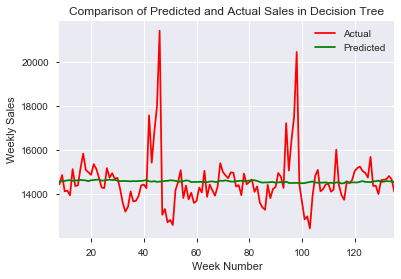

In [89]:
dt.plot(kind = 'line', x = 'Week', y = 'Actual', color = 'red', ax = plt.gca())
dt.plot(kind = 'line', x = 'Week', y = 'Predicted', color = 'green', ax = plt.gca())
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted and Actual Sales in Decision Tree')
plt.show()

In [90]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 8524.362915281685
Mean Squared Error: 129274485.55590406
Root Mean Squared Error: 11369.89382342263


In [91]:
print("R-squared for Train:",gscv_gbmr.score(train_X, train_y))

R-squared for Train: 0.5595731699169404


##### Prediction on test data using Gradient Boosting Model

In [92]:
GBM_Pred_Output = pd.read_csv('samplesubmission.csv')
GBM_Pred_Output['Weekly_Sales'] = gscv_gbmr.predict(test_X)
GBM_Pred_Output.to_csv('GBM_Pred_Output.csv')

## Support Vector Regression (SVR)

In [93]:
# from sklearn.svm import SVR

In [94]:
# svr = SVR(gamma = 'scale')
# svr.fit(train_X, train_y)
# predict_X = svr.predict(train_X)

In [95]:
# print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
# print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

In [96]:
# print("R-squared for Train:",svr.score(train_X, train_y))

### Tuning a SVR Model

In [97]:
# para = {'C' : [5, 10],
#               'gamma': [10 ** x for x in range(-8, -5)]}

In [98]:
# svr = GridSearchCV(svr ,para, cv = 5)
# grid_result = svr.fit(train_X, train_y)

In [99]:
# svr.best_score_

In [100]:
# svr.best_score_

### Final SVR Model

In [101]:
# svr = SVR(C = 5, gamma = 1e-8)
# svr.fit(train_X, train_y)
# predict_X = svr.predict(train_X)

In [102]:
# dt = pd.DataFrame({ 'Actual' : train_y, 'Predicted' : predict_X, 'Week' : train.Weeks})
# dt.head()

In [103]:
# dt = dt.groupby('Week').apply(lambda x : np.mean(x))

In [104]:
# dt.plot(kind = 'line', x = 'Week', y = 'Actual', color = 'red', ax = plt.gca())
# dt.plot(kind = 'line', x = 'Week', y = 'Predicted', color = 'green', ax = plt.gca())
# plt.xlabel('Week Number')
# plt.ylabel('Weekly Sales')
# plt.title('Comparison of Predicted and Actual Sales in Decision Tree')
# plt.show()

In [105]:
# print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
# print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

In [106]:
# print("R-squared for Train:",svr.score(train_X, train_y))

##### Prediction on test data using Support Vector Regression Model

In [107]:
# SVR_Pred_Output = pd.read_csv('samplesubmission.csv')
# SVR_Pred_Output['Weekly_Sales'] = svr.predict(test_X)
# SVR_Pred_Output.to_csv('SVR_Pred_Output.csv')

## K-Nearest Neighbor (KNN)

In [108]:
from sklearn.neighbors import KNeighborsRegressor

In [109]:
KNN = KNeighborsRegressor(n_neighbors = 5)
KNN.fit(train_X, train_y)
predict_X = KNN.predict(train_X)

In [110]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))  
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 7472.819802881133
Mean Squared Error: 119931463.64311366
Root Mean Squared Error: 10951.322460922866


In [111]:
print("R-squared for Train:",KNN.score(train_X, train_y))

R-squared for Train: 0.5914040258414637


### Tuning a KNN Model

In [112]:
rmse_val = []
rmse = []
for K in range(2, 10):
    K = K + 1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(train_X, train_y) 
    predict_X = model.predict(train_X) 
    error = np.sqrt(metrics.mean_squared_error(train_y ,predict_X)) 
    rmse_val.append(error) 
    print('RMSE value for k = ' , K , 'is:', error)

RMSE value for k =  3 is: 10375.628310314461
RMSE value for k =  4 is: 10541.496743297494
RMSE value for k =  5 is: 10951.322460922866
RMSE value for k =  6 is: 11334.299281599866
RMSE value for k =  7 is: 11550.703114353333
RMSE value for k =  8 is: 11714.61782822258
RMSE value for k =  9 is: 11828.799890638958
RMSE value for k =  10 is: 11989.640235666484


In [113]:
min(rmse_val)

10375.628310314461

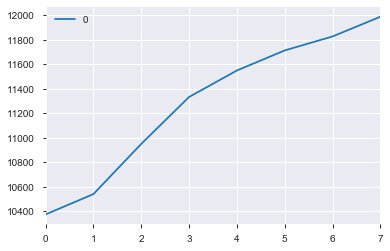

In [114]:
a = pd.DataFrame(rmse_val) 
a.plot()

### Final KNN Model

In [124]:
KNN = KNeighborsRegressor(n_neighbors = 3)
KNN.fit(train_X, train_y)
predict_X = KNN.predict(train_X)

In [116]:
dt = pd.DataFrame({ 'Actual' : train_y, 'Predicted' : predict_X, 'Week' : train.Weeks})
dt.head()

,Actual,Predicted,Week
0,24924.50,29756.630000,72.0
1,50605.27,29756.630000,72.0
2,13740.12,29756.630000,72.0
3,39954.04,29756.630000,72.0
4,32229.38,35919.716667,72.0


In [117]:
dt = dt.groupby('Week').apply(lambda x : np.mean(x))

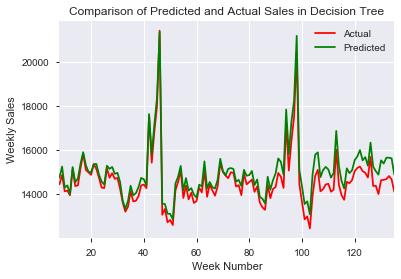

In [118]:
dt.plot(kind = 'line', x = 'Week', y = 'Actual', color = 'red', ax = plt.gca())
dt.plot(kind = 'line', x = 'Week', y = 'Predicted', color = 'green', ax = plt.gca())
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted and Actual Sales in Decision Tree')
plt.show()

In [119]:
print('Mean Absolute Error:', metrics.mean_absolute_error(train_y, predict_X))
print('Mean Squared Error:', metrics.mean_squared_error(train_y, predict_X))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_y, predict_X)))

Mean Absolute Error: 7027.410603845941
Mean Squared Error: 107653662.83379893
Root Mean Squared Error: 10375.628310314461


In [125]:
print("R-squared for Train:",KNN.score(train_X, train_y))

R-squared for Train: 0.6332334159766058


##### Prediction on test data using K-Nearest Neighbor Model

In [121]:
KNN_Pred_Output = pd.read_csv('samplesubmission.csv')
KNN_Pred_Output['Weekly_Sales'] = KNN.predict(test_X)
KNN_Pred_Output.to_csv('KNN_Pred_Output.csv')